In [1]:
from dpm.models import (
    OrdinalLayer, OrdinalModel,
    OrdinalLoss,
    exp_cdf, erf_cdf, tanh_cdf,
    normal_cdf, laplace_cdf, cauchy_cdf
)
from dpm.visualize import (
    plot_ordinal_classes,
    plot_ordinal_classes_from_layer
)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [28]:
import pandas as pd
import numpy as np

# DATA
red = pd.read_csv('winequality-red.csv', sep=';')
white = pd.read_csv('winequality-white.csv', sep=';')

wine = pd.concat((red, white))

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer

gaussian_columns = ['alcohol', 'chlorides', 'fixed acidity',
                    'density',
                    'pH', 'sulphates', 'volatile acidity']
power_columns = ['citric acid', 'free sulfur dioxide', 'residual sugar',
                 'total sulfur dioxide']
column_transformer = ColumnTransformer([
    ('gaussian', StandardScaler(), gaussian_columns),
    ('power', PowerTransformer(), power_columns)
])

X = column_transformer.fit_transform(wine)

y = wine.quality.values.astype(np.long)
# Map y from (3-8) to (0-5)
y -= y.min()

from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(X, y, 
                                                      test_size=0.20,
                                                      stratify=y, 
                                                      random_state=666)

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).long()
y_test= torch.tensor(y_test).long()


from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

num_features = len(gaussian_columns + power_columns)
num_classes = len(np.unique(y))

torch.Size([5197, 11]) torch.Size([5197])
torch.Size([1300, 11]) torch.Size([1300])


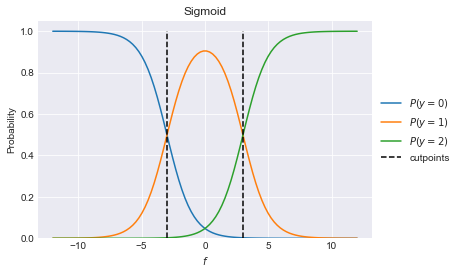

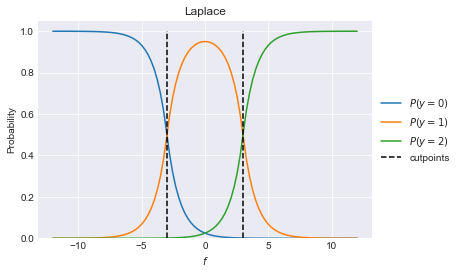

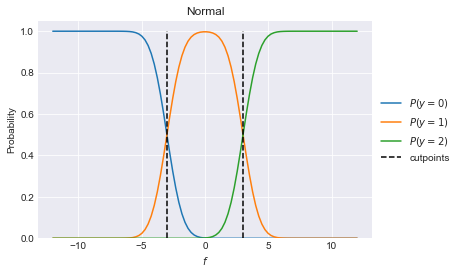

In [29]:
f = torch.linspace(-12, 12, 100)
cutpoints = torch.tensor([-3, 3])

plot_ordinal_classes(f, cutpoints, title="Sigmoid")
plt.show()
plot_ordinal_classes(f, cutpoints, func=laplace_cdf, title='Laplace')
plt.show()
plot_ordinal_classes(f, cutpoints, func=normal_cdf, title='Normal')
plt.show()

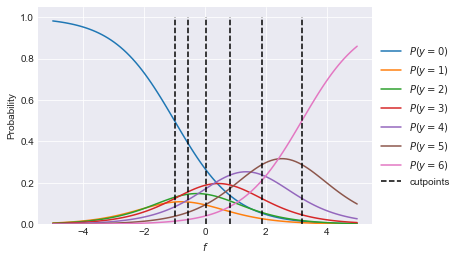

In [30]:
# Define Models

predictor = nn.Sequential(
    nn.Linear(X.shape[1], 64),
    nn.ELU(),
    nn.Linear(64, 64),
    nn.ELU(),
    nn.Linear(64, 1, bias=False)
)

model = OrdinalModel(predictor, OrdinalLayer(num_classes))

criterion = OrdinalLoss('mean')

opti = optim.Adam(model.parameters(), lr=1e-2)

# quick plot of init values
f = torch.linspace(-5, 5, 100)
plot_ordinal_classes_from_layer(f, model.ordinal)

In [34]:
epochs = 200

for epoch in range(epochs):
    
    model.train()
    
    total_loss = 0
    
    for (data, label) in train_loader:
        
        opti.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, label)
        
        loss.backward()
        
        opti.step()
        
        total_loss += loss.item() * len(label)
        
    print(f"[INFO {epoch}: LOSS: {total_loss/len(X_train)}]")
        
    model.eval()
    with torch.no_grad():
        output = model(X_train)
        print(f"[INFO {epoch}: ACC : {(output.argmax(-1) == y_train).float().mean():.3f}]")
        print(f"[INFO {epoch}: TOP : {(abs(output.argmax(-1) - y_train) < 2).float().mean():.3f}]")
        output = model(X_test)
        loss = criterion(output, y_test)
    print(f"[INFO {epoch}: LOSS: {loss.item()}]")
    print(f"[INFO {epoch}: ACC : {(output.argmax(-1) == y_test).float().mean():.3f}]")
    print(f"[INFO {epoch}: TOP : {(abs(output.argmax(-1) - y_test) < 2).float().mean():.3f}]")
    print()
        

[INFO 0: LOSS: 1.0407974940665712]
[INFO 0: ACC : 0.573]
[INFO 0: TOP : 0.962]
[INFO 0: LOSS: 1.0326240062713623]
[INFO 0: ACC : 0.572]
[INFO 0: TOP : 0.951]

[INFO 1: LOSS: 1.0292354039510947]
[INFO 1: ACC : 0.572]
[INFO 1: TOP : 0.969]
[INFO 1: LOSS: 1.0252588987350464]
[INFO 1: ACC : 0.569]
[INFO 1: TOP : 0.965]

[INFO 2: LOSS: 1.0219237885154944]
[INFO 2: ACC : 0.567]
[INFO 2: TOP : 0.959]
[INFO 2: LOSS: 1.0485843420028687]
[INFO 2: ACC : 0.570]
[INFO 2: TOP : 0.952]

[INFO 3: LOSS: 1.0262471639309476]
[INFO 3: ACC : 0.580]
[INFO 3: TOP : 0.964]
[INFO 3: LOSS: 1.007959246635437]
[INFO 3: ACC : 0.580]
[INFO 3: TOP : 0.961]

[INFO 4: LOSS: 1.0240214410506236]
[INFO 4: ACC : 0.551]
[INFO 4: TOP : 0.971]
[INFO 4: LOSS: 1.0674546957015991]
[INFO 4: ACC : 0.545]
[INFO 4: TOP : 0.955]

[INFO 5: LOSS: 1.0130743724762625]
[INFO 5: ACC : 0.555]
[INFO 5: TOP : 0.967]
[INFO 5: LOSS: 1.072833776473999]
[INFO 5: ACC : 0.545]
[INFO 5: TOP : 0.958]

[INFO 6: LOSS: 1.0087586620437978]
[INFO 6: ACC 

[INFO 51: LOSS: 0.8473533285749126]
[INFO 51: ACC : 0.663]
[INFO 51: TOP : 0.984]
[INFO 51: LOSS: 1.0818665027618408]
[INFO 51: ACC : 0.576]
[INFO 51: TOP : 0.955]

[INFO 52: LOSS: 0.8460838229169473]
[INFO 52: ACC : 0.684]
[INFO 52: TOP : 0.985]
[INFO 52: LOSS: 1.0689107179641724]
[INFO 52: ACC : 0.584]
[INFO 52: TOP : 0.957]

[INFO 53: LOSS: 0.8420906356946767]
[INFO 53: ACC : 0.672]
[INFO 53: TOP : 0.984]
[INFO 53: LOSS: 1.084166407585144]
[INFO 53: ACC : 0.566]
[INFO 53: TOP : 0.955]

[INFO 54: LOSS: 0.8390728873267916]
[INFO 54: ACC : 0.678]
[INFO 54: TOP : 0.986]
[INFO 54: LOSS: 1.1049867868423462]
[INFO 54: ACC : 0.566]
[INFO 54: TOP : 0.955]

[INFO 55: LOSS: 0.8354859112179323]
[INFO 55: ACC : 0.666]
[INFO 55: TOP : 0.983]
[INFO 55: LOSS: 1.0792555809020996]
[INFO 55: ACC : 0.586]
[INFO 55: TOP : 0.955]

[INFO 56: LOSS: 0.8260651084467014]
[INFO 56: ACC : 0.673]
[INFO 56: TOP : 0.986]
[INFO 56: LOSS: 1.1113206148147583]
[INFO 56: ACC : 0.574]
[INFO 56: TOP : 0.955]

[INFO 57: L

[INFO 101: LOSS: 0.6718517697864435]
[INFO 101: ACC : 0.750]
[INFO 101: TOP : 0.992]
[INFO 101: LOSS: 1.240182638168335]
[INFO 101: ACC : 0.582]
[INFO 101: TOP : 0.952]

[INFO 102: LOSS: 0.6733030669616236]
[INFO 102: ACC : 0.752]
[INFO 102: TOP : 0.994]
[INFO 102: LOSS: 1.2327516078948975]
[INFO 102: ACC : 0.599]
[INFO 102: TOP : 0.944]

[INFO 103: LOSS: 0.6774871506919442]
[INFO 103: ACC : 0.753]
[INFO 103: TOP : 0.993]
[INFO 103: LOSS: 1.2637405395507812]
[INFO 103: ACC : 0.582]
[INFO 103: TOP : 0.946]

[INFO 104: LOSS: 0.6678470049554485]
[INFO 104: ACC : 0.767]
[INFO 104: TOP : 0.994]
[INFO 104: LOSS: 1.2131049633026123]
[INFO 104: ACC : 0.608]
[INFO 104: TOP : 0.955]

[INFO 105: LOSS: 0.6664876209122873]
[INFO 105: ACC : 0.736]
[INFO 105: TOP : 0.992]
[INFO 105: LOSS: 1.2631369829177856]
[INFO 105: ACC : 0.571]
[INFO 105: TOP : 0.948]

[INFO 106: LOSS: 0.6621648754457888]
[INFO 106: ACC : 0.767]
[INFO 106: TOP : 0.994]
[INFO 106: LOSS: 1.2502778768539429]
[INFO 106: ACC : 0.582]


[INFO 150: LOSS: 0.5806117737570794]
[INFO 150: ACC : 0.796]
[INFO 150: TOP : 0.995]
[INFO 150: LOSS: 1.4312748908996582]
[INFO 150: ACC : 0.581]
[INFO 150: TOP : 0.936]

[INFO 151: LOSS: 0.5823920357793897]
[INFO 151: ACC : 0.811]
[INFO 151: TOP : 0.995]
[INFO 151: LOSS: 1.4610081911087036]
[INFO 151: ACC : 0.578]
[INFO 151: TOP : 0.932]

[INFO 152: LOSS: 0.5895772064640495]
[INFO 152: ACC : 0.790]
[INFO 152: TOP : 0.996]
[INFO 152: LOSS: 1.424628496170044]
[INFO 152: ACC : 0.591]
[INFO 152: TOP : 0.945]

[INFO 153: LOSS: 0.5916216639296147]
[INFO 153: ACC : 0.804]
[INFO 153: TOP : 0.996]
[INFO 153: LOSS: 1.460035800933838]
[INFO 153: ACC : 0.597]
[INFO 153: TOP : 0.942]

[INFO 154: LOSS: 0.5879832312696962]
[INFO 154: ACC : 0.771]
[INFO 154: TOP : 0.995]
[INFO 154: LOSS: 1.4337615966796875]
[INFO 154: ACC : 0.592]
[INFO 154: TOP : 0.942]

[INFO 155: LOSS: 0.6013432901617148]
[INFO 155: ACC : 0.778]
[INFO 155: TOP : 0.995]
[INFO 155: LOSS: 1.4947603940963745]
[INFO 155: ACC : 0.560]
[

[INFO 199: LOSS: 0.545393066656734]
[INFO 199: ACC : 0.824]
[INFO 199: TOP : 0.997]
[INFO 199: LOSS: 1.5899531841278076]
[INFO 199: ACC : 0.594]
[INFO 199: TOP : 0.929]



In [35]:
# What are the learned ordinal params?

print(model.ordinal.theta.detach())

print(model.ordinal.threshold.detach())

tensor([-2.5183,  5.5560,  7.2890,  6.4653,  5.1686,  6.7841])
tensor([-2.5183,  3.0415, 10.3312, 16.7980, 21.9723, 28.7575])


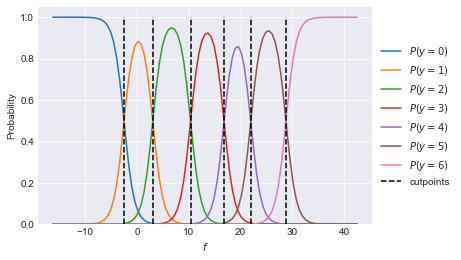

In [36]:
num_points = 101
cutpoints = model.ordinal.threshold.detach()
offset = cutpoints.std() + 2

# why manual f? in case you want to zoom in

f = torch.linspace(cutpoints.min() - offset, 
                   cutpoints.max() + offset, 
                   num_points)


plot_ordinal_classes_from_layer(f, model.ordinal)